In [2]:
# Data Cleaning, EDA, importing libraries and importing the dataset
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('https://raw.githubusercontent.com/nickkatsy/python_ml_ect_/master/income.csv')


df.info()


df.columns = df.columns.str.replace('.','_')


df.isna().sum()

df.nunique()

df['income'] = [0 if X == '<=50K' else 1 for X in df['income']]


print(df.dtypes)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             25000 non-null  int64 
 1   workclass       25000 non-null  object
 2   fnlwgt          25000 non-null  int64 
 3   education       25000 non-null  object
 4   education.num   25000 non-null  int64 
 5   marital.status  25000 non-null  object
 6   occupation      25000 non-null  object
 7   relationship    25000 non-null  object
 8   race            25000 non-null  object
 9   sex             25000 non-null  object
 10  capital.gain    25000 non-null  int64 
 11  capital.loss    25000 non-null  int64 
 12  hours.per.week  25000 non-null  int64 
 13  native.country  25000 non-null  object
 14  income          25000 non-null  object
dtypes: int64(6), object(9)
memory usage: 2.9+ MB
age                int64
workclass         object
fnlwgt             int64
education         

<Axes: >

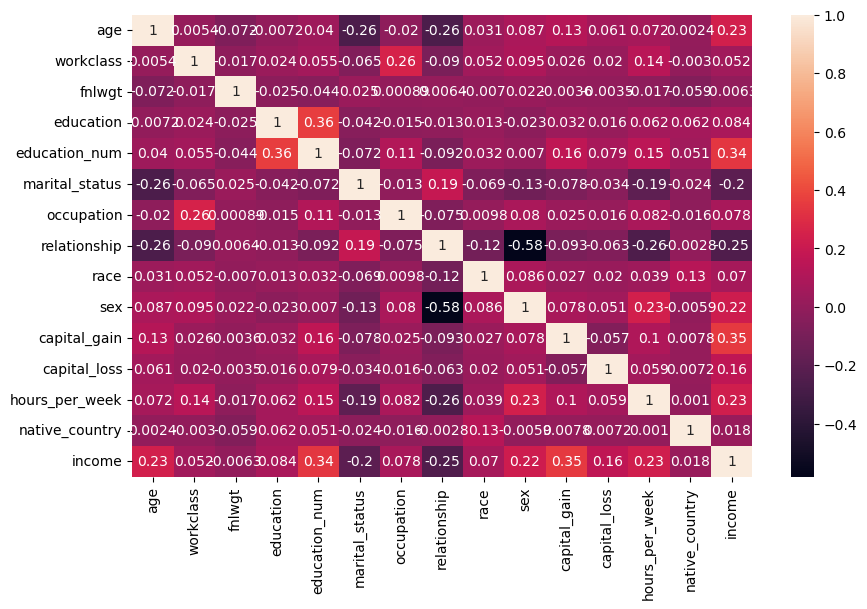

In [3]:
# using labelencoder to turn all features into numerical values so I can then make a correlation heatmap and
# provide brief visuals descriptive statistics on the training data

df1 = df.copy()

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

for i in df1:
    df1[i] = le.fit_transform(df1[i])



import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(10,6))
sns.heatmap(df1.corr(),annot=True)

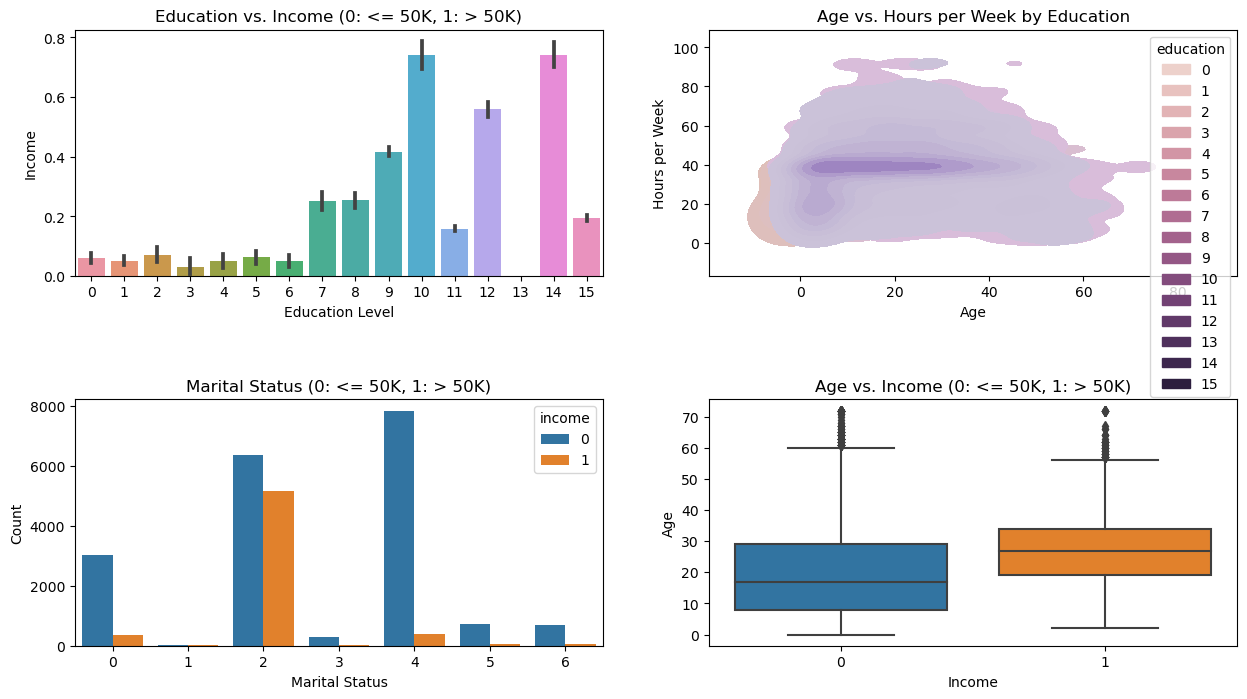

In [4]:
# a user-defined function consisiting of subplots of the features is created to visualize the dataset
def subplots(df1):
    plt_,axs = plt.subplots(2,2,figsize=(15, 8),gridspec_kw={'hspace':0.5})

    sns.barplot(x='education',y='income',data=df1, ax=axs[0,0])
    axs[0,0].set_title('Education vs. Income (0: <= 50K, 1: > 50K)')
    axs[0,0].set_xlabel('Education Level')
    axs[0,0].set_ylabel('Income')

    sns.kdeplot(x='age', y='hours_per_week', hue='education',data=df1,fill=True,ax=axs[0,1])
    axs[0,1].set_title('Age vs. Hours per Week by Education')
    axs[0,1].set_xlabel('Age')
    axs[0,1].set_ylabel('Hours per Week')

    sns.countplot(x='marital_status',hue='income',data=df1,ax=axs[1,0])
    axs[1,0].set_title('Marital Status (0: <= 50K, 1: > 50K)')
    axs[1,0].set_xlabel('Marital Status')
    axs[1,0].set_ylabel('Count')

    sns.boxplot(x='income',y='age',data=df1,ax=axs[1,1])
    axs[1,1].set_title('Age vs. Income (0: <= 50K, 1: > 50K)')
    axs[1,1].set_xlabel('Income')
    axs[1,1].set_ylabel('Age')

    plt.show()

subplots(df1)

In [5]:
#income is the dependent variable, so it is set to y after that a train/test split is implemented as well as a encoder
# to turn the string variables into numerical features and standard scaler is used to scale the numerical features
# All of this takes place through steps in sci-kit learns make_column_transformer. This makes it so the dataset can be ran
# through a pipeline.
X = df.drop('income',axis=1)
y = df['income']



from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.20,random_state=42)


from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse_output=False)

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()


from sklearn.compose import make_column_transformer

ct = make_column_transformer(
    (ohe,X.select_dtypes(include='object').columns),
    (sc,X.select_dtypes(include=['int64','float64']).columns),remainder='passthrough')


ct.fit_transform(X)


array([[ 0.        ,  0.        ,  0.        , ..., 13.50972664,
        -0.21719211,  2.40117761],
       [ 0.        ,  0.        ,  0.        , ..., -0.14793361,
        -0.21719211, -0.03597233],
       [ 0.        ,  0.        ,  0.        , ..., -0.14793361,
        -0.21719211, -0.03597233],
       ...,
       [ 0.        ,  1.        ,  0.        , ..., -0.14793361,
        -0.21719211, -0.03597233],
       [ 0.        ,  0.        ,  0.        , ..., -0.14793361,
        -0.21719211, -0.03597233],
       [ 0.        ,  0.        ,  0.        , ..., -0.14793361,
        -0.21719211, -0.03597233]])

In [6]:
# I will import 'make_pipeline' from sci-kit learn, but before running the pipeline, I will import all models that 
#I will be using for the testing portion.


from sklearn.pipeline import make_pipeline


from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()



from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,BaggingClassifier
rfc = RandomForestClassifier()
gbc = GradientBoostingClassifier()

from sklearn.tree import DecisionTreeClassifier
trees = DecisionTreeClassifier()


from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()


BC = BaggingClassifier()



from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=10)


In [7]:
#now, using a user-defined function I created, I will make the pipeline through that mentioned user-defined function and
# then, when the pipeline translates the steps from the transformer, it will fit the training data sets and then X_test
# will be used for predictions and predicted probabilities and the scoring metrics for the predcitions will be:
# accuracy and f1 score. After that, the predicted probabilities will be calculated be the roc_auc score and all of this
# will be used for each model 

from sklearn.metrics import roc_auc_score,accuracy_score,roc_curve,f1_score

def evaluate_model(model,X_train,X_test,y_train,y_test):
    pipe = make_pipeline(ct,model).fit(X_train,y_train)
    pred = pipe.predict(X_test)
    pred_prob = pipe.predict_proba(X_test)[:,1]
    acc = accuracy_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc = roc_auc_score(y_test,pred_prob)
    print(f'{model.__class__.__name__}, --Accuracy Score-- {acc*100:.2f}%; --ROC-- {roc*100:.2f}%; --F1-- {f1*100:.2f}%')
    return pred,pred_prob


lr_pred,lr_pred_prob = evaluate_model(lr, X_train, X_test, y_train, y_test)
rfc_pred,rfc_pred_prob = evaluate_model(rfc, X_train, X_test, y_train, y_test)
gbc_pred,gbc_pred_prob = evaluate_model(gbc, X_train, X_test, y_train, y_test)
trees_pred,trees_pred_prob = evaluate_model(trees, X_train, X_test, y_train, y_test)
nb_pred,nb_pred_prob = evaluate_model(nb, X_train, X_test, y_train, y_test)
lda_pred,lda_pred_prob = evaluate_model(lda, X_train, X_test, y_train, y_test)
BC_pred,BC_pred_prob = evaluate_model(BC, X_train, X_test, y_train, y_test)
knn_pred,knn_pred_prob = evaluate_model(knn, X_train, X_test, y_train, y_test)

LogisticRegression, --Accuracy Score-- 84.68%; --ROC-- 90.69%; --F1-- 66.31%
RandomForestClassifier, --Accuracy Score-- 85.00%; --ROC-- 89.86%; --F1-- 67.53%
GradientBoostingClassifier, --Accuracy Score-- 86.50%; --ROC-- 92.08%; --F1-- 69.85%
DecisionTreeClassifier, --Accuracy Score-- 80.30%; --ROC-- 75.13%; --F1-- 62.10%
GaussianNB, --Accuracy Score-- 50.20%; --ROC-- 71.99%; --F1-- 49.29%
LinearDiscriminantAnalysis, --Accuracy Score-- 83.48%; --ROC-- 89.46%; --F1-- 62.73%
BaggingClassifier, --Accuracy Score-- 84.00%; --ROC-- 88.60%; --F1-- 64.85%
KNeighborsClassifier, --Accuracy Score-- 83.48%; --ROC-- 87.51%; --F1-- 62.73%


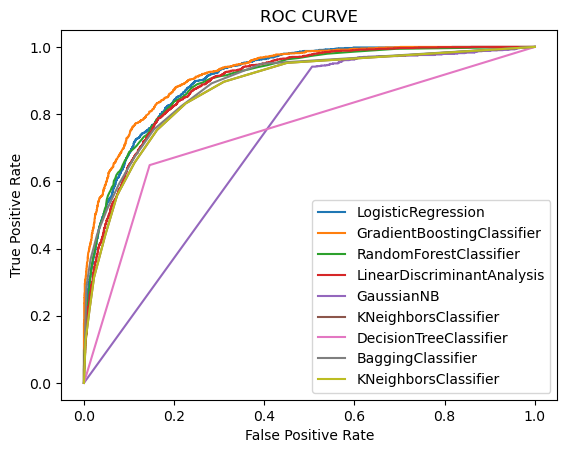

In [8]:
# This plot shows the roc curves for each model visually in a single plot

def ROC(y_test,y_pred_prob,model):
    fpr,tpr, _ = roc_curve(y_test,y_pred_prob)
    plt.plot(fpr,tpr,label=model.__class__.__name__)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC CURVE')


ROC(y_test, lr_pred_prob,lr)
ROC(y_test,gbc_pred_prob,gbc)
ROC(y_test, rfc_pred_prob, rfc)
ROC(y_test,lda_pred_prob,lda)
ROC(y_test, nb_pred_prob, nb)
ROC(y_test, knn_pred_prob, knn)
ROC(y_test,trees_pred_prob,trees)
ROC(y_test,BC_pred_prob,BC)
ROC(y_test,knn_pred_prob,knn)
plt.legend()
plt.show()

In [9]:
# Now a RandomizedGridSearch will be used to tune the hyperparameters of each individual model. This may take a while.
# Hyperparameter tuning is used to 'tweak' the models to determine the optimal results on each model

from sklearn.model_selection import RandomizedSearchCV

import numpy as np

lr_random_param_grid = {
    'logisticregression__C': np.logspace(-4,4,9),
    'logisticregression__penalty': ['l1','l2']
}

lr_random_search = RandomizedSearchCV(
    make_pipeline(ct,lr), 
    lr_random_param_grid,
    n_iter=10,
    scoring='roc_auc',
    cv=5,
    random_state=42
).fit(X_train, y_train)


# Best Logistic Regression model
best_lr_estimator = lr_random_search.best_estimator_
lr_random_pred = best_lr_estimator.predict(X_test)
lr_random_pred_prob = best_lr_estimator.predict_proba(X_test)[:,1]
print(f'Logistic Regression - Best Parameters: {lr_random_search.best_params_}')
print(f'Logistic Regression - Best ROC-AUC Score: {lr_random_search.best_score_ * 100:.2f}%')


# Random forest Random Grid Search
rfc_param_grid = {
    'randomforestclassifier__n_estimators': [50,100,200],
    'randomforestclassifier__max_depth': [None,10,20],
    'randomforestclassifier__min_samples_split': [2,5,10],
    'randomforestclassifier__min_samples_leaf': [1,2,4]
}

rfc_random_search = RandomizedSearchCV(
    make_pipeline(ct,rfc),
    rfc_param_grid,
    n_iter=10,
    scoring='roc_auc',
    cv=5, 
    random_state=42
).fit(X_train, y_train)

best_rfc_estimator = rfc_random_search.best_estimator_
rfc_random_pred = best_rfc_estimator.predict(X_test)
rfc_random_pred_prob = best_rfc_estimator.predict_proba(X_test)[:, 1]
print(f'Random Forest - Best Parameters: {rfc_random_search.best_params_}')
print(f'Random Forest - Best ROC-AUC Score: {rfc_random_search.best_score_ * 100:.2f}')



gbc_random_param_grid = {
    'gradientboostingclassifier__n_estimators': [50,100,200],
    'gradientboostingclassifier__learning_rate': [0.01,0.1,0.2],
    'gradientboostingclassifier__max_depth': [3,4,5],
    'gradientboostingclassifier__min_samples_split': [2,5,10],
}

gbc_random_search = RandomizedSearchCV(
    make_pipeline(ct,gbc),
    gbc_random_param_grid,
    n_iter=10,
    scoring='roc_auc',
    cv=5,
    random_state=42
).fit(X_train,y_train)


# Best Gradient Boosting model using random gridsearch
best_gbc_estimator = gbc_random_search.best_estimator_
gbc_random_pred = best_gbc_estimator.predict(X_test)
gbc_random_pred_prob = best_gbc_estimator.predict_proba(X_test)[::,1]
print(f'Gradient Boosting - Best Parameters: {gbc_random_search.best_params_}')
print(f'Gradient Boosting - Best ROC-AUC Score: {gbc_random_search.best_score_ * 100:.2f}%')



# K-Nearest Neighbors RandomGridSearch

knn_param_grid = {
    'kneighborsclassifier__n_neighbors': [3,5,7,10],
    'kneighborsclassifier__weights': ['uniform','distance'],
    'kneighborsclassifier__p': [1,2]
}

knn_grid_search = RandomizedSearchCV(
    make_pipeline(ct,knn),
    knn_param_grid,
    scoring='roc_auc',
    cv=5).fit(X_train, y_train)


best_knn_estimator = knn_grid_search.best_estimator_
knn_grid_pred = best_knn_estimator.predict(X_test)
knn_grid_pred_prob = best_knn_estimator.predict_proba(X_test)[::,1]
print(f'K-Nearest Neighbors - Best Parameters: {knn_grid_search.best_params_}')
print(f'K-Nearest Neighbors - Best ROC-AUC Score: {knn_grid_search.best_score_ * 100:.2f}%')


# Decision Tree Randomized Grid Search

dt_param_dist = {
    'decisiontreeclassifier__criterion': ['gini','entropy'],
    'decisiontreeclassifier__max_depth': [None,10,20,30],
    'decisiontreeclassifier__min_samples_split': [2,5,10],
    'decisiontreeclassifier__min_samples_leaf': [1,2,4]
}

dt_rand_search = RandomizedSearchCV(
    make_pipeline(ct,trees),
    dt_param_dist,
    n_iter=10,
    scoring='roc_auc',
    cv=5,
    random_state=42
).fit(X_train,y_train)


best_dt_estimator = dt_rand_search.best_estimator_
dt_rand_pred = best_dt_estimator.predict(X_test)
dt_rand_pred_prob = best_dt_estimator.predict_proba(X_test)[::,1]
print(f'Decision Trees - Best Parameters: {dt_rand_search.best_params_}')
print(f'Decision Trees - Best ROC-AUC Score: {dt_rand_search.best_score_ * 100:.2f}%')



#LDA Ranomized GridSearch

lda_param_dist = {
    'lineardiscriminantanalysis__solver': ['svd','lsqr','eigen'],
    'lineardiscriminantanalysis__shrinkage': [None,'auto']
}

lda_rand_search = RandomizedSearchCV(
    make_pipeline(ct,lda),
    lda_param_dist,
    n_iter=10,
    scoring='roc_auc',
    cv=5,
    random_state=42
).fit(X_train, y_train)

best_lda_estimator = lda_rand_search.best_estimator_
lda_rand_pred = best_lda_estimator.predict(X_test)
lda_rand_pred_prob = best_lda_estimator.predict_proba(X_test)[::,1]
print(f'Linear Discriminant Analysis - Best Parameters: {lda_rand_search.best_params_}')
print(f'Linear Discriminant Analysis - Best ROC-AUC Score: {lda_rand_search.best_score_ * 100:.2f}%')


# Bagging Classifier Randomized Grid Search
BC_param_grid = {
    'baggingclassifier__n_estimators': [50,100,200],
    'baggingclassifier__max_samples': [1.0,0.8,0.6],
    'baggingclassifier__max_features': [1.0,0.8,0.6],
}

BC_rand_search = RandomizedSearchCV(
    make_pipeline(ct,BC),
    BC_param_grid,
    n_iter=10,
    scoring='roc_auc',
    cv=5,
    random_state=42
).fit(X_train,y_train)

best_BC_estimator = BC_rand_search.best_estimator_
BC_rand_pred = best_BC_estimator.predict(X_test)
BC_rand_pred_prob = best_BC_estimator.predict_proba(X_test)[::,1]
print(f'Bagging Classifier - Best Parameters: {BC_rand_search.best_params_}')
print(f'Bagging Classifier - Best ROC-AUC Score: {BC_rand_search.best_score_ * 100:.2f}%')

Logistic Regression - Best Parameters: {'logisticregression__penalty': 'l2', 'logisticregression__C': 10.0}
Logistic Regression - Best ROC-AUC Score: 90.66%
Random Forest - Best Parameters: {'randomforestclassifier__n_estimators': 100, 'randomforestclassifier__min_samples_split': 5, 'randomforestclassifier__min_samples_leaf': 4, 'randomforestclassifier__max_depth': None}
Random Forest - Best ROC-AUC Score: 91.73
Gradient Boosting - Best Parameters: {'gradientboostingclassifier__n_estimators': 100, 'gradientboostingclassifier__min_samples_split': 10, 'gradientboostingclassifier__max_depth': 4, 'gradientboostingclassifier__learning_rate': 0.2}
Gradient Boosting - Best ROC-AUC Score: 92.60%
K-Nearest Neighbors - Best Parameters: {'kneighborsclassifier__weights': 'distance', 'kneighborsclassifier__p': 2, 'kneighborsclassifier__n_neighbors': 7}
K-Nearest Neighbors - Best ROC-AUC Score: 87.23%
Decision Trees - Best Parameters: {'decisiontreeclassifier__min_samples_split': 10, 'decisiontreecl